# Import Library 

In [67]:
from datetime import datetime, time, date
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 
#################################################################
from torch.utils.data import Dataset, DataLoader  
from sklearn.preprocessing import MinMaxScaler  
from copy import deepcopy as dc  
import torch.nn as nn 
import torch  
##################################################################
# Importing PyTorch library for deep learning tasks
# Importing neural network related classes and functions from PyTorch
# Importing deepcopy function for creating deep copies of objects
# Importing MinMaxScaler for feature scaling
# Importing Dataset and DataLoader for handling datasets in PyTorch

# Data collection

In [68]:
data =pd.read_csv(f'AMZN.csv')

# Data Exploratoir 

In [69]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [70]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6516.000000,6516.000000,6516.000000,6516.000000,6516.000000,6.516000e+03
mean,31.611626,31.991995,31.193432,31.599740,31.599740,1.425338e+08
std,48.095343,48.659651,47.464476,48.060258,48.060258,1.401619e+08
min,0.070313,0.072396,0.065625,0.069792,0.069792,9.744000e+06
25%,1.998875,2.028500,1.964750,2.001250,2.001250,6.888182e+07
50%,6.456750,6.535500,6.353250,6.444250,6.444250,1.059050e+08
75%,38.451375,38.688000,38.203001,38.464625,38.464625,1.607700e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [72]:
data['Date'].describe()

count           6516
unique          6516
top       1997-05-15
freq               1
Name: Date, dtype: object

In [73]:
data['Close'].describe()

count    6516.000000
mean       31.599740
std        48.060258
min         0.069792
25%         2.001250
50%         6.444250
75%        38.464625
max       186.570496
Name: Close, dtype: float64

In [74]:
data=data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [75]:
#Selecting the appropriate device (GPU if available, otherwise CPU) for tensor operations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [76]:
data['Date'] = pd.to_datetime(data['Date'])

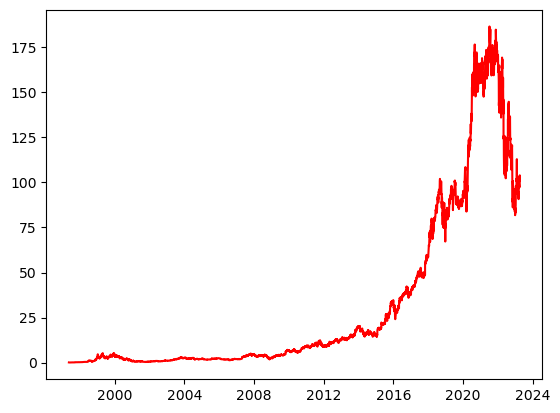

In [77]:
plt.plot(data['Date'],data['Close'],color='red')

# Data Preprocessing

In [78]:
def prepare_dataframe_for_lstm(df, n_steps):
    """
    Preprocesses a dataframe for LSTM model by creating lag features.
    Args:
    df (DataFrame): Input dataframe with 'Date' and 'Close' columns.
    n_steps (int): Number of lag steps.
    Returns:
    DataFrame: Processed dataframe with lag features.
    """
    df = dc(df)  
    #Make a deep copy of the input dataframe
    df.set_index('Date', inplace=True)  # Set 'Date' column as index
    #Create lag features for 'Close' column
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)  
    #Drop rows with NaN values resulting from lag shift

    return df 

In [80]:
lookback = 7  
#Number of lag steps to consider
shifted_df = prepare_dataframe_for_lstm(data, lookback)  
#Prepare dataframe with lag features for LSTM
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


# Normalization 

In [81]:
scaler = MinMaxScaler(feature_range=(-1,1)) 
#Initialize MinMaxScaler to scale features between -1 and 1
shifted_df_as_np = scaler.fit_transform(shifted_df) 
#Scale the dataframe using MinMaxScaler
shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [84]:
# Extract features (all columns except the first one) from the scaled dataframe
X = shifted_df_as_np[:, 1:]  
# Extract target variable (the first column) from the scaled dataframe
y = shifted_df_as_np[:, 0]  

# Print the shapes of X (features) and y (target variable)
print("Shape of X features:", X.shape)
print("Shape of y target variable:", y.shape)


Shape of X features: (6509, 7)
Shape of y target variable: (6509,)


In [95]:
X = dc(np.flip(X, axis=1))  
#Reverse the order of lagged features along the time axis
#Print the updated X after reversing the order of lagged features
print("Updated X after reversing the order of lagged features along the time axis:\n", X)


Updated X after reversing the order of lagged features along the time axis:
 [[-0.99969839 -0.99982128 -0.99983244 ... -0.99998325 -1.
  -0.99995531]
 [-0.99982128 -0.99983244 -0.99987154 ... -1.         -0.99994415
  -0.99991063]
 [-0.99983244 -0.99987154 -0.99998325 ... -0.99994415 -0.99989946
  -0.99993855]
 ...
 [ 0.05779984  0.05158     0.0506149  ...  0.07431453  0.09308121
   0.10690997]
 [ 0.05158     0.0506149   0.04203581 ...  0.09308121  0.10691495
   0.09747299]
 [ 0.0506149   0.04203581  0.07431453 ...  0.10691495  0.09747802
   0.11398769]]


In [96]:
split_index = int(len(X) * 0.95)  
# Calculate the index to split the data into training and testing sets
print("Index to split the data into training and testing sets:", split_index)

Index to split the data into training and testing sets: 6183


In [97]:
#Split the data into training and testing sets for features (X) and target variable (y)
X_train = X[:split_index]  
#Training features from the beginning to the split index
X_test = X[split_index:]   
#Testing features from the split index to the end
y_train = y[:split_index]  
#training target variable from the beginning to the split index
y_test = y[split_index:]   
#Testing target variable from the split index to the end


print("Shape of X_train training features:", X_train.shape)
print("Shape of X_test testing features:", X_test.shape)
print("Shape of y_train training target variable:", y_train.shape)
print("Shape of y_test testing target variable:", y_test.shape)

Shape of X_train training features: (6183, 7)
Shape of X_test testing features: (326, 7)
Shape of y_train training target variable: (6183,)
Shape of y_test testing target variable: (326,)


In [98]:
#Reshape the training and testing sets to be compatible with LSTM input shape
X_train = X_train.reshape((-1, lookback, 1))  
#Reshape training features to (batch_size, lookback, 1)
X_test = X_test.reshape((-1, lookback, 1))   
#Reshape testing features to (batch_size, lookback, 1)
y_train = y_train.reshape((-1, 1))  
#Reshape training target variable to (batch_size, 1)
y_test = y_test.reshape((-1, 1))    
#Reshape testing target variable to (batch_size, 1)


print("Shape of X_train reshaped training features:", X_train.shape)
print("Shape of X_test reshaped testing features:", X_test.shape)
print("Shape of y_train reshaped training target variable:", y_train.shape)
print("Shape of y_test reshaped testing target variable)", y_test.shape)

Shape of X_train reshaped training features: (6183, 7, 1)
Shape of X_test reshaped testing features: (326, 7, 1)
Shape of y_train reshaped training target variable: (6183, 1)
Shape of y_test reshaped testing target variable) (326, 1)


In [99]:
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [103]:
class TimeSeriesDataset(Dataset):
    """
    PyTorch dataset class for time series data.
    """
    
    def __init__(self, X, y):
        """
        Initialize the dataset with features (X) and target variable (y).
        Args:
        X (numpy.ndarray): Features.
        y (numpy.ndarray): Target variable.
        """
        self.X = X  #Features
        self.y = y  #Target variable

    def __len__(self):
        """
        Return the length of the dataset.
        Returns:
        int: Length of the dataset.
        """
        return len(self.X)

    def __getitem__(self, i):
        """
        Get a sample from the dataset at the given index.
        Args:
        i (int): Index of the sample.
        Returns:
        tuple: Tuple containing the feature and target variable at the given index.
        """
        return self.X[i], self.y[i]

#Create training and testing datasets
train_dataset = TimeSeriesDataset(X_train, y_train)  
#Training dataset
#Testing dataset
test_dataset = TimeSeriesDataset(X_test, y_test)    

In [104]:
train_dataset

In [105]:
batch_size = 16  
#Set the batch size for DataLoader
#Create DataLoader for training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#DataLoader for training dataset with batch_size=16 and shuffle=True
#Create DataLoader for testing dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#DataLoader for testing dataset with batch_size=16 and shuffle=False

In [108]:
for _, batch in enumerate(train_loader):
    #Get a batch of data from the training loader
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    #the shapes of features and target variables in the batch
    print("Shape of x_batch (features):", x_batch.shape)
    print("Shape of y_batch (target variable):", y_batch.shape)
    #Break after printing the shapes of the first batch
    break

Shape of x_batch (features): torch.Size([16, 7, 1])
Shape of y_batch (target variable): torch.Size([16, 1])


# Model Creation  LSTM

In [109]:
class LSTM(nn.Module):
    """
    LSTM model for time series forecasting.
    """

    def __init__(self, input_size, hidden_size, num_stacked_layers):
        """
        Initialize the LSTM model.
        Args:
        input_size (int): Size of the input features.
        hidden_size (int): Size of the hidden state.
        num_stacked_layers (int): Number of stacked LSTM layers.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)  # LSTM layer
        self.fc = nn.Linear(hidden_size, 1)  # Fully connected layer for output prediction

    def forward(self, x):
        """
        Forward pass of the LSTM model.
        Args:
        x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).
        Returns:
        torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        # Initialize the hidden and cell state
        out, _ = self.lstm(x, (h0, c0))  # LSTM forward pass
        out = self.fc(out[:, -1, :])  # Fully connected layer for final prediction
        return out


In [112]:
model = LSTM(1, 4, 1)  
#Initialize LSTM model with input_size=1, hidden_size=4, and num_stacked_layers=1
model.to(device)  
#Move the model to the specified device (GPU or CPU)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [114]:
def train_one_epoch():
    """
    Function to train the model for one epoch.
    """
    
    model.train(True)  
    #Set the model to training mode
    print(f'Epoch: {epoch + 1}')  
    #Print the current epoch number
    running_loss = 0.0  
    #Initialize running loss for the epoch
    
    for batch_index, batch in enumerate(train_loader):
        #Iterate over batches in the training loader
        
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)  
        #Move batch data to device
        
        output = model(x_batch)  
        #Forward pass: compute model predictions
        loss = loss_function(output, y_batch)  
        #Calculate the loss
        running_loss += loss  
        #Accumulate the loss for the epoch
        optimizer.zero_grad()  
        #Zero the gradients
        loss.backward()  
        #Backpropagation: compute gradients
        optimizer.step()  
        #Update model parameters using gradients
        
        if batch_index % 100 == 99:  
            #Print loss every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss:{1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0  
            #Reset running loss after printing


In [115]:
def validate_one_epoch():
    """
    Function to validate the model for one epoch.
    """
    model.train(False)  
    #Set the model to evaluation mode (no gradient computation)
    running_loss = 0.0  
    #Initialize running loss for the validation
    
    for batch_index, batch in enumerate(test_loader):
        #Iterate over batches in the test loader
        
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)  
        #Move batch data to device
        
        with torch.no_grad():
            #Perform inference without gradient computation
            output = model(x_batch)  
            #Forward pass: compute model predictions
            loss = loss_function(output, y_batch)  
            #Calculate the loss
            running_loss += loss  
            #Accumulate the loss for the epoch
    
    avg_loss_across_batches = running_loss / len(test_loader)  
    #Calculate average loss
    
    #the average validation loss
    print('Val Loss : {0:.3f}'.format(avg_loss_across_batches))
    print("***********************") 


In [116]:
learning_rate = 0.001  
#Set the learning rate for the optimizer
num_epochs = 10  
#Set the number of epochs for training
loss_function = nn.MSELoss()  
#Define the loss function (Mean Squared Error)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
#Initialize the optimizer (Adam)

#Iterate over epochs
for epoch in range(num_epochs):
    #Train the model for one epoch
    train_one_epoch()
    
    #Validate the model for one epoch
    validate_one_epoch()

Epoch: 1
Batch 100, Loss:0.780
Batch 200, Loss:0.199
Batch 300, Loss:0.044
Val Loss : 0.018
***********************
Epoch: 2
Batch 100, Loss:0.006
Batch 200, Loss:0.004
Batch 300, Loss:0.003
Val Loss : 0.008
***********************
Epoch: 3
Batch 100, Loss:0.002
Batch 200, Loss:0.001
Batch 300, Loss:0.001
Val Loss : 0.006
***********************
Epoch: 4
Batch 100, Loss:0.001
Batch 200, Loss:0.001
Batch 300, Loss:0.001
Val Loss : 0.005
***********************
Epoch: 5
Batch 100, Loss:0.000
Batch 200, Loss:0.000
Batch 300, Loss:0.000
Val Loss : 0.005
***********************
Epoch: 6
Batch 100, Loss:0.000
Batch 200, Loss:0.000
Batch 300, Loss:0.000
Val Loss : 0.004
***********************
Epoch: 7
Batch 100, Loss:0.000
Batch 200, Loss:0.000
Batch 300, Loss:0.000
Val Loss : 0.004
***********************
Epoch: 8
Batch 100, Loss:0.000
Batch 200, Loss:0.000
Batch 300, Loss:0.000
Val Loss : 0.004
***********************
Epoch: 9
Batch 100, Loss:0.000
Batch 200, Loss:0.000
Batch 300, Loss:0.0

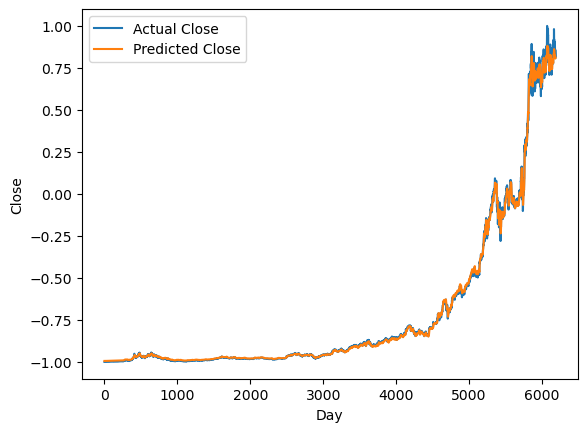

In [118]:
with torch.no_grad():
    #Perform inference on training data without gradient computation
    predicted = model(X_train.to(device)).to('cpu').numpy()  # Get predicted values
    
# Plot actual and predicted close prices
plt.plot(y_train, label='Actual Close')  
#Plot actual close prices
plt.plot(predicted, label='Predicted Close')  
#Plot predicted close prices
plt.xlabel('Day')  
plt.ylabel('Close')  
plt.legend()  
plt.show()  

In [121]:
train_predictions = predicted.flatten()  
#Flatten the predicted values
dummies = np.zeros((X_train.shape[0], lookback + 1))  
#Initialize an array for inverse transformation
dummies[:, 0] = train_predictions  
#Fill the first column with the predicted values
dummies = scaler.inverse_transform(dummies) 
#Inverse transform the scaled values
train_predictions = dc(dummies[:, 0]) 
#Deep copy the inverse transformed predicted values
train_predictions 

array([  0.62374397,   0.62271016,   0.62203207, ..., 168.93080305,
       168.44557891, 168.97473446])

In [123]:
#Initialize an array for inverse transformation
dummies = np.zeros((X_train.shape[0], lookback + 1))
#Fill the first column with the actual target variable values (flattened)
dummies[:, 0] = y_train.flatten()
#Inverse transform the scaled values using the scaler
dummies = scaler.inverse_transform(dummies)
#Deep copy the inverse transformed target variable values
new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

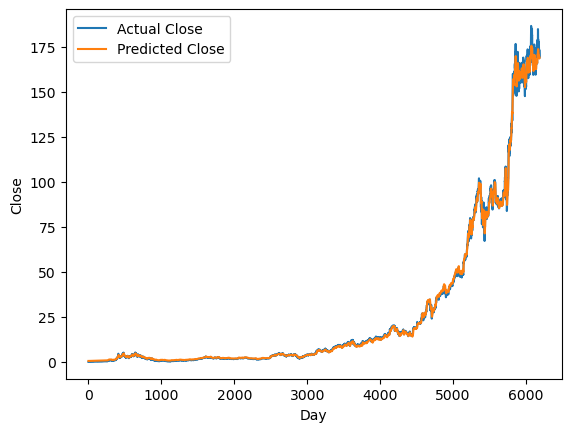

In [124]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [126]:
#Perform inference on the test data using the trained model and convert predictions to NumPy array
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

#Initialize an array for inverse transformation
dummies = np.zeros((X_test.shape[0], lookback + 1))
#Fill the first column with the predicted values
dummies[:, 0] = test_predictions
#nverse transform the scaled values using the scaler
dummies = scaler.inverse_transform(dummies)
#Deep copy the inverse transformed predicted values
test_predictions = dc(dummies[:, 0])
test_predictions

array([168.19521881, 167.94989438, 167.14245472, 167.392259  ,
       167.69412067, 167.91756833, 167.64542039, 167.81345357,
       167.56558351, 167.39685001, 166.78351113, 167.17830461,
       166.73289886, 165.79618838, 164.90205312, 164.15025027,
       163.36890045, 163.80798106, 163.84751043, 162.97652475,
       162.75276027, 161.81399328, 160.56630026, 158.54378264,
       154.46894475, 152.14654971, 149.1032161 , 146.47100572,
       144.81003846, 144.9021699 , 146.63940574, 148.62985854,
       149.77352018, 147.38872966, 151.51067264, 154.12000578,
       156.74039958, 158.27131233, 158.77335535, 157.73569824,
       158.19370981, 158.16916514, 158.52554088, 157.69177795,
       156.58372165, 155.20516261, 152.93897132, 153.20132585,
       153.83907601, 154.05749357, 153.6470762 , 153.72489548,
       152.68247506, 151.62801018, 148.17693821, 145.20432059,
       144.0171055 , 145.43156445, 145.77609583, 145.06655695,
       146.34725967, 149.23607191, 152.46328492, 155.66

In [127]:
#Initialize an array for inverse transformation with the shape of X_test and lookback+1 columns
dummies = np.zeros((X_test.shape[0], lookback + 1))
#Fill the first column with the actual target variable values (flattened)
dummies[:, 0] = y_test.flatten()
#Inverse transform the scaled values using the scaler
dummies = scaler.inverse_transform(dummies)
#Deep copy the inverse transformed target variable values
new_y_test = dc(dummies[:, 0])

new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

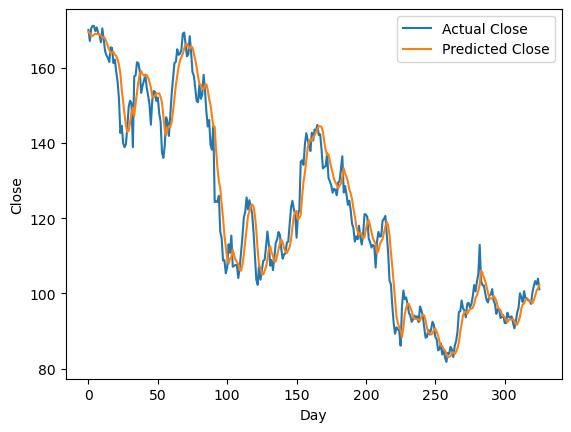

In [58]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()